# Signal to noise calculations for the Huntsman Telephoto Array

This notebook contains signal to noise calculations for the Huntsman Telephoto Array.

## Standard imports

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.colors as colours

## Import gunagala

`gungala` is the library that performs the SNR/sensitivity/ETC calculations. The main submodule is `imager` which includes the `Imager` class which represents an astronomical imaging instrument.

In [4]:
from gunagala import imager

/mnt/data/ajh/Documents/gunagala-repair/gunagala/gunagala/imager.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/mnt/data/ajh/Documents/virtualenvs/astro/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/mnt/data/ajh/Documents/virtualenvs/astro/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/mnt/data/ajh/Documents/virtualenvs/astro/lib/python3.5/site-packages/ipykernel/kernelapp.py", lin

## Create imagers

The `gunagala.imager.create_imagers()` creates a dictionary of `Imager` objects based on the `gunagala/data/performance.yaml` configuration file as well as performance data files in `gunagala/data/performance_data`. The instrument configuration/specifications should be set by editing these files.

Currently the file describes 2 variants of the Australian Space Eye concept and a '5 lens' version of the Huntsman Telephoto Array. This version of the Huntsman Telephoto Array can represent the nominal full array of 10 lenses for the case where the lenses are divided equally between g' and r' band filters, which is expected to be the usual observing mode.

In [5]:
imagers = imager.create_imagers()
huntsman = imagers['canon_sbig_dark']  # A 5 lens (per filter) array, dark of Moon
huntsman_bright = imagers['canon_sbig_bright'] # The same but at full Moon
waves_h = huntsman.wavelengths

## Inspect imager properties

Many properties of the imagers can be accessed as properties of the `Imager` object.

### Field of view

In [6]:
huntsman.pixel_scale

<Quantity 2.84866996 arcsec / pix>

In [7]:
huntsman.field_of_view

<Quantity [2.63185452, 1.98140822] deg>

In [8]:
huntsman.camera.resolution

<Quantity [3326., 2504.] pix>

### Filter profiles 

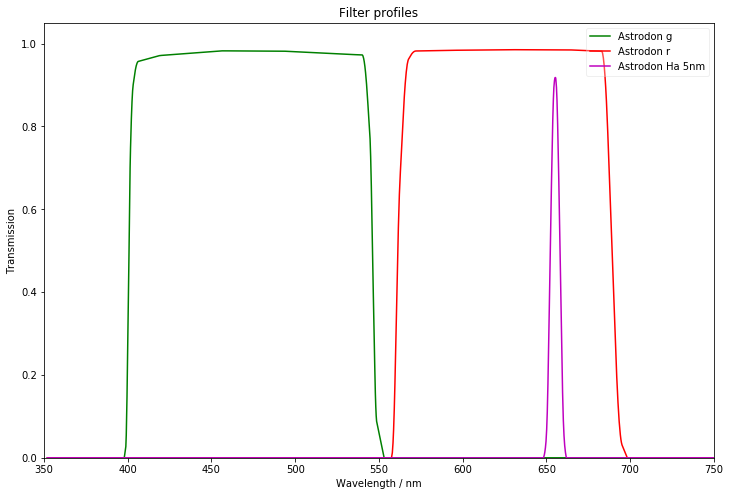

In [9]:
plt.plot(waves_h, huntsman.filters['g'].transmission(waves_h), 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.filters['r'].transmission(waves_h), 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.filters['Ha_5nm'].transmission(waves_h), 'm-', label='Astrodon Ha 5nm')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Transmission')
plt.title('Filter profiles')
plt.xlim(350, 750)
plt.ylim(0, 1.05)
plt.gcf().set_size_inches(12,8)

In [10]:
huntsman.filters['g'].FWHM

<Quantity 145.51289297 nm>

In [11]:
huntsman.filters['g'].lambda_c

<Quantity 473.48435842 nm>

In [12]:
huntsman.filters['r'].FWHM

<Quantity 128.09927319 nm>

In [13]:
huntsman.filters['r'].lambda_c

<Quantity 625.31546518 nm>

### Image sensor quantum efficiency

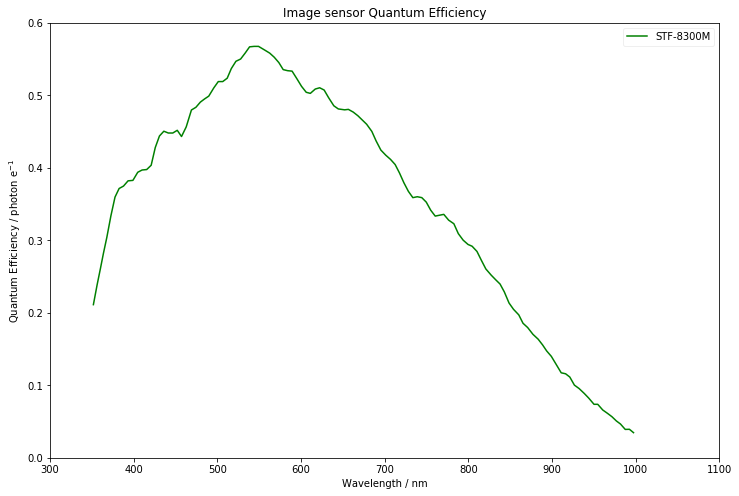

In [14]:
plt.plot(huntsman.camera.wavelengths, huntsman.camera.QE, 'g-', label='STF-8300M')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Quantum Efficiency / photon e$^{-1}$')
plt.title('Image sensor Quantum Efficiency')
plt.xlim(300, 1100)
plt.ylim(0,0.6)
plt.gcf().set_size_inches(12,8)

### End to end efficiency

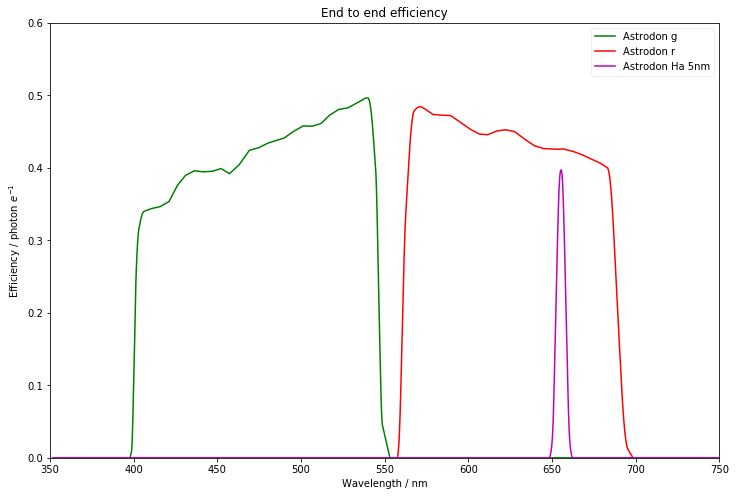

In [15]:
plt.plot(waves_h, huntsman.efficiencies['g'], 'g-', label='Astrodon g')
plt.plot(waves_h, huntsman.efficiencies['r'], 'r-', label='Astrodon r')
plt.plot(waves_h, huntsman.efficiencies['Ha_5nm'], 'm-', label='Astrodon Ha 5nm')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)
plt.xlabel('Wavelength / nm')
plt.ylabel('Efficiency / photon $e^{-1}$')
plt.title('End to end efficiency')
plt.xlim(350, 750)
plt.ylim(0, 0.6)
plt.gcf().set_size_inches(12,8)

### PSF model

Uses a Moffat profile with 2 arcsecond FWHM an a shape parameter of 4.5. This is an upper limit for this value (which corresponded to the least 'wing-y' PSF) as this is the best fit value for a PSF where the scattering wings are due only to Kolmogorov atmospheric turbulence, i.e. instrumental scattering is assumed to be neglible.

In [16]:
huntsman.psf.FWHM

<Quantity 2. arcsec>

In [17]:
huntsman.psf.shape

Parameter('alpha', value=4.5)

In [18]:
huntsman.psf.peak

<Quantity 0.70747499 1 / pix>

In [19]:
huntsman.psf.n_pix

<Quantity 4.28191643 pix>

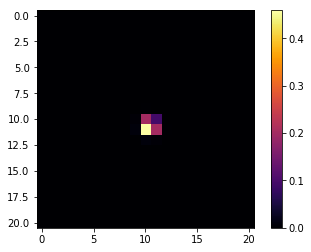

In [20]:
plt.imshow(huntsman.psf.pixellated(offsets=(0.33, 0.67)), interpolation='none', cmap='inferno')
plt.colorbar()

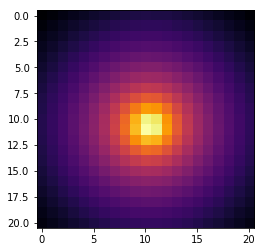

In [21]:
plt.imshow(huntsman.psf.pixellated(offsets=(0.33, 0.67)), interpolation='none', cmap='inferno', norm=colours.LogNorm())

### Sky background model

For Huntsman we use the `Simple` sky model from `gunagala`, which has a single pre-defined sky brightness value (in AB magnitudes per square arcsecond) for each filter bandpass. At present `gunagala` uses sky brightness values for different Moon states from the DECam Exposure Time Calculator v7, from http://www.ctio.noao.edu/noao/content/Exposure-Time-Calculator-ETC-0

In [22]:
huntsman.sky.surface_brightness('g')

<Magnitude 22.1 mag(AB)>

In [23]:
huntsman.sky.surface_brightness('r')

<Magnitude 21.1 mag(AB)>

In [24]:
huntsman.sky.surface_brightness('Ha_5nm')

<Magnitude 21.1 mag(AB)>

In [25]:
huntsman_bright.sky.surface_brightness('g')

<Magnitude 19.4 mag(AB)>

### Detected sky background levels

Pre-calculated for each filter. Also dark current for comparison.

#### Dark time

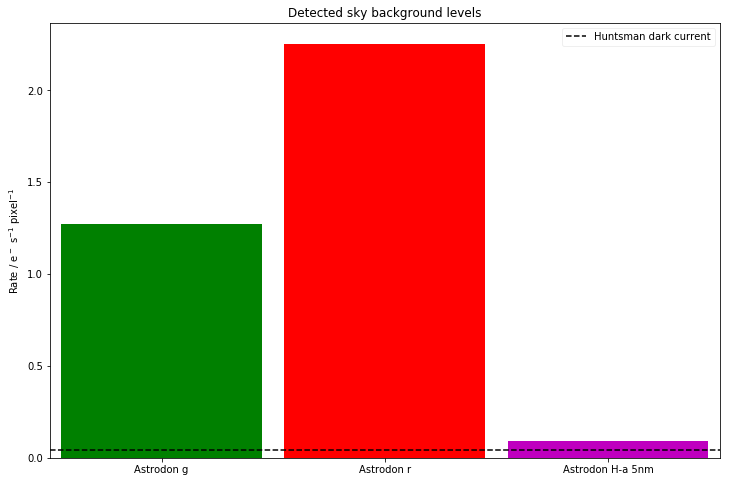

In [26]:
plt.bar((1, 2, 3), (huntsman.sky_rate['g'].value, huntsman.sky_rate['r'].value, huntsman.sky_rate['Ha_5nm'].value),
        width=0.9, align='center', color=('g', 'r', 'm'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 3.5, linestyle='dashed', label='Huntsman dark current')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)

plt.xticks((1, 2, 3), 
           ('Astrodon g', 'Astrodon r', 'Astrodon H-a 5nm'))
plt.xlim(0.5,3.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

#### Full Moon

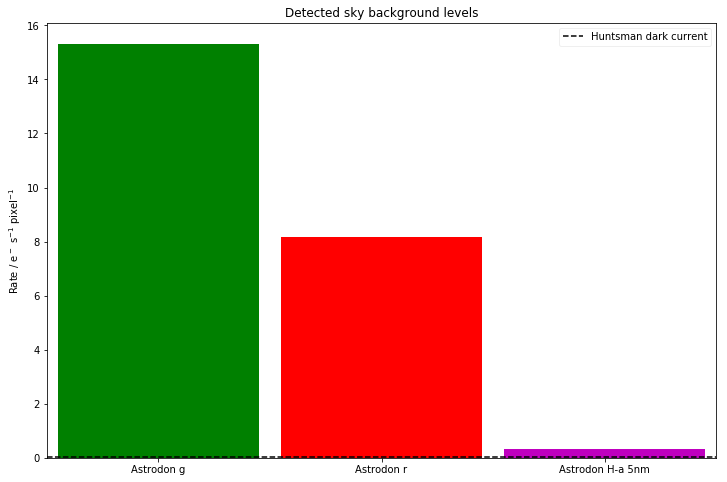

In [27]:
plt.bar((1, 2, 3), 
        (huntsman_bright.sky_rate['g'].value,
         huntsman_bright.sky_rate['r'].value,
         huntsman_bright.sky_rate['Ha_5nm'].value),
        width=0.9, align='center', color=('g', 'r', 'm'))
plt.hlines(huntsman.camera.dark_current.value, 0.5, 3.5, linestyle='dashed', label='Huntsman dark current')

plt.legend(loc='upper right', fancybox=True, framealpha=0.3)

plt.xticks((1, 2, 3), 
           ('Astrodon g', 'Astrodon r', 'Astrodon H-a 5nm'))
plt.xlim(0.5,3.5)
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Detected sky background levels')
plt.gcf().set_size_inches(12, 8)

## Point source sensitivity

### Single 1 minute exposure

#### Dark time

In [28]:
huntsman.point_source_limit(total_exp_time=1*u.minute,
                            filter_name='g',
                            snr_target=5.0,
                            sub_exp_time=60*u.second)

<Magnitude 20.05374971 mag(AB)>

In [29]:
huntsman.point_source_saturation_mag(sub_exp_time=60*u.second, filter_name='g')

<Magnitude 13.24167291 mag(AB)>

#### Full Moon

In [30]:
huntsman_bright.point_source_limit(total_exp_time=1*u.minute,
                                   filter_name='g',
                                   snr_target=5.0,
                                   sub_exp_time=60*u.second)

<Magnitude 19.09941337 mag(AB)>

In [31]:
huntsman_bright.point_source_saturation_mag(sub_exp_time=60*u.second, filter_name='g')

<Magnitude 13.28168866 mag(AB)>

### Single exposures from 10 seconds to 5 minutes, dark time

In [32]:
ts = np.arange(10,301,5) * u.second

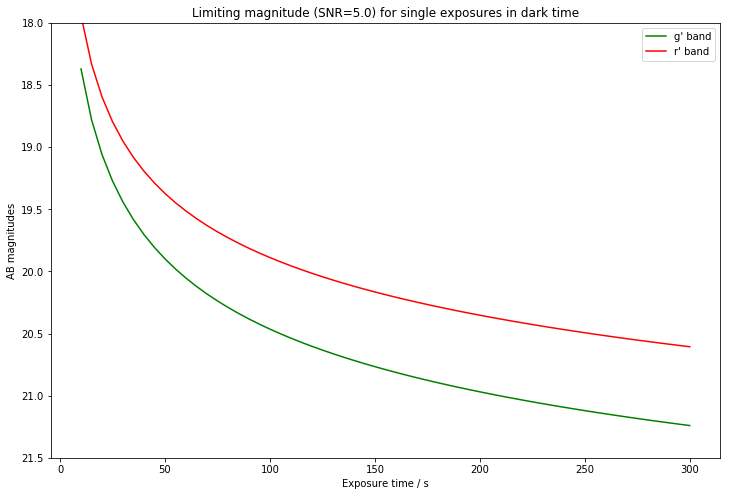

In [33]:
plt.plot(ts, huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts, filter_name='g', snr_target=5.0), 
         'g-', label="g' band")
plt.plot(ts, huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts, filter_name='r', snr_target=5.0),
         'r-', label="r' band")
plt.ylim(21.5, 18)
plt.legend()
plt.title("Limiting magnitude (SNR=5.0) for single exposures in dark time")
plt.xlabel("Exposure time / s")
plt.ylabel("AB magnitudes")
plt.gcf().set_size_inches(12, 8)

### 1% photometry with dithering, dark time.

In practice we will almost always observe each field with multiple, dithered sub-exposures. This increases dynamic range, improves flat fielding accuracy and improves cosmic ray rejection. For these short total exposure times we assume 5 sub-exposures.

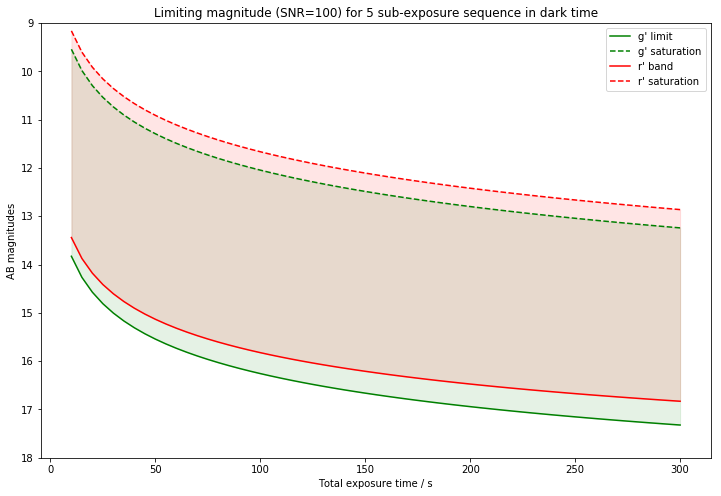

In [34]:
g_100 = huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts/5, filter_name='g', snr_target=100.0)
g_sat = huntsman.point_source_saturation_mag(sub_exp_time=ts/5, filter_name='g')
r_100 = huntsman.point_source_limit(total_exp_time=ts, sub_exp_time=ts/5, filter_name='r', snr_target=100.0)
r_sat = huntsman.point_source_saturation_mag(sub_exp_time=ts/5, filter_name='r')

plt.plot(ts.to(u.second), g_100, 'g-', label="g' limit")
plt.plot(ts.to(u.second), g_sat, 'g--', label="g' saturation")
plt.fill_between(ts.to(u.second).value, g_100.value, g_sat.value, color='g', alpha=0.1)

plt.plot(ts.to(u.second), r_100, 'r-', label="r' band")
plt.plot(ts.to(u.second), r_sat, 'r--', label="r' saturation")
plt.fill_between(ts.to(u.second).value, r_100.value, r_sat.value, color='r', alpha=0.1)

plt.ylim(18,9)
plt.legend()
plt.title("Limiting magnitude (SNR=100) for 5 sub-exposure sequence in dark time")
plt.xlabel("Total exposure time / s")
plt.ylabel("AB magnitudes")
plt.gcf().set_size_inches(12, 8)

### 1% photometry with dithering, full Moon

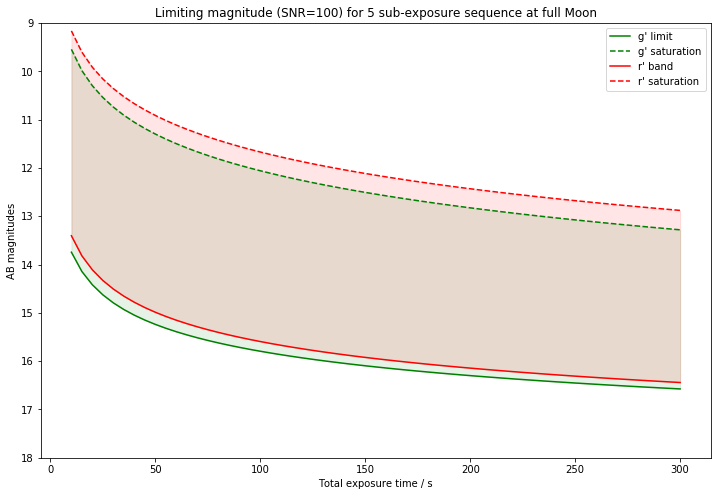

In [35]:
g_100 = huntsman_bright.point_source_limit(total_exp_time=ts, sub_exp_time=ts/5, filter_name='g', snr_target=100.0)
g_sat = huntsman_bright.point_source_saturation_mag(sub_exp_time=ts/5, filter_name='g')
r_100 = huntsman_bright.point_source_limit(total_exp_time=ts, sub_exp_time=ts/5, filter_name='r', snr_target=100.0)
r_sat = huntsman_bright.point_source_saturation_mag(sub_exp_time=ts/5, filter_name='r')

plt.plot(ts.to(u.second), g_100, 'g-', label="g' limit")
plt.plot(ts.to(u.second), g_sat, 'g--', label="g' saturation")
plt.fill_between(ts.to(u.second).value, g_100.value, g_sat.value, color='g', alpha=0.1)

plt.plot(ts.to(u.second), r_100, 'r-', label="r' band")
plt.plot(ts.to(u.second), r_sat, 'r--', label="r' saturation")
plt.fill_between(ts.to(u.second).value, r_100.value, r_sat.value, color='r', alpha=0.1)

plt.ylim(18,9)
plt.legend()
plt.title("Limiting magnitude (SNR=100) for 5 sub-exposure sequence at full Moon")
plt.xlabel("Total exposure time / s")
plt.ylabel("AB magnitudes")
plt.gcf().set_size_inches(12, 8)